In [1]:
import os
from pathlib import Path

testfolder = 'Simulations/1axis'

if not os.path.exists(testfolder):
    os.makedirs(testfolder)
    
print ("Your simulation will be stored in %s" % testfolder)

Your simulation will be stored in Simulations/1axis


In [2]:
import bifacial_radiance as br
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# This information helps with debugging and getting support :)
import sys, platform
print("Working on a ", platform.system(), platform.release())
print("Python version ", sys.version)
print("Pandas version ", pd.__version__)
print("bifacial_radiance version ", br.__version__)
print("pyplot ", plt.matplotlib.__version__)

Working on a  Darwin 21.6.0
Python version  3.11.5 (main, Sep 11 2023, 08:19:27) [Clang 14.0.6 ]
Pandas version  2.0.3
bifacial_radiance version  0.4.2+164.ge460768.dirty
pyplot  3.7.2


In [4]:
simulationname = '1axis-groundscan'

# Location
lat = 39.7555
lon = -105.2211

# Scene Parameters
azimuth_ang=90 # Facing south
tilt=30

# MakeModule Parameters
moduletype='PVmod'
numpanels=1
module_x = 2 # m
module_y = 1 # m. slope we will measure
sensorsy=2
sensorsground=5

# SceneDict Parameters
pitch = 5.7 # m
albedo = 0.2
clearance_height = 0.5 # m  
nMods = 4 
nRows = 3

sceneDict = {'tilt':10,'pitch':5.7,'clearance_height':0.2,'azimuth':180, 'nMods': 20, 'nRows': 7} 

In [5]:
demo = br.RadianceObj(simulationname,path = testfolder)
demo.setGround(albedo)
epwfile = demo.getEPW(lat, lon)

path = Simulations/1axis
Loading albedo, 1 value(s), 0.200 avg
1 nonzero albedo values.
Getting weather file: USA_CO_Golden-NREL.724666_TMY3.epw
 ... OK!


In [6]:
module=demo.makeModule(name=moduletype,x=module_x,y=module_y)


Module Name: PVmod
Module PVmod updated in module.json
Pre-existing .rad file objects/PVmod.rad will be overwritten



In [7]:
metdata = demo.readWeatherFile(epwfile, coerce_year=2021, starttime='2021-06-01', endtime='2021-06-30_23')

8760 line in WeatherFile. Assuming this is a standard hourly WeatherFile for the year for purposes of saving Gencumulativesky temporary weather files in EPW folder.
Coercing year to 2021
Filtering dates
Saving file EPWs/metdata_temp.csv, # points: 8760
Calculating Sun position for Metdata that is right-labeled  with a delta of -30 mins. i.e. 12 is 11:30 sunpos


In [8]:
demo.gendaylit(timeindex=0)  

'skies/sky2_39.74_-105.18_2021-06-01_0500.rad'

In [9]:
scene = demo.makeScene(module,sceneDict)

In [10]:
octfile = demo.makeOct()

Created 1axis-groundscan.oct


In [11]:
analysis = br.AnalysisObj(octfile, demo.name)

In [12]:
hub_height = 1.5
pitch = 5.7
sazm = 90
fixed_tilt_angle = None
gcr = 2 / pitch
cumulativesky = True

trakerParams = {
    'limit_angle': 50,
    'angledelta': 30,
    'backtrack': True,
    'gcr': gcr,
    'cumulativesky': cumulativesky,
    'azimuth': sazm,
    'fixed_tilt_angle': fixed_tilt_angle
}

In [13]:
trackerdict = demo.set1axis(**trakerParams)

Saving file EPWs/1axis_-60.0.csv, # points: 60
Saving file EPWs/1axis_-30.0.csv, # points: 60
Saving file EPWs/1axis_-0.0.csv, # points: 250
Saving file EPWs/1axis_30.0.csv, # points: 80


In [14]:
if cumulativesky:
    demo.genCumSky1axis()
else:
    demo.gendaylit1axis()

message: There were 60 sun up hours in this climate file
Total Ibh/Lbh: 0.000000
Created skyfile skies/1axis_-60.0.rad
message: There were 60 sun up hours in this climate file
Total Ibh/Lbh: 0.000000
Created skyfile skies/1axis_-30.0.rad
message: There were 249 sun up hours in this climate file
Total Ibh/Lbh: 0.000000
Created skyfile skies/1axis_-0.0.rad
message: There were 80 sun up hours in this climate file
Total Ibh/Lbh: 0.000000
Created skyfile skies/1axis_30.0.rad


In [15]:
sceneDict = {
    'pitch': pitch,
    'hub_height': hub_height,
    'nMods': 5,
    'nRows': 2,
    'tilt': fixed_tilt_angle,
    'sazm': sazm
}

In [16]:
trakerdict = demo.makeScene1axis(module=moduletype, sceneDict=sceneDict)
trakerdict = demo.makeOct1axis()


Making .rad files for cumulativesky 1-axis workflow
4 Radfiles created in /objects/

Making 4 octfiles in root directory.
Created 1axis_-60.0.oct
Created 1axis_-30.0.oct
Created 1axis_-0.0.oct
Created 1axis_30.0.oct


In [17]:
sensorsgroundvalues = np.array([3, 5, 10, 20, 30, 100, 150, 200, 250, 300, 400, 500])
angles = np.array([-0.0, -30.0, -60.0, 30.0])

In [18]:
resultsdict = {}

for i, sensorsground in enumerate(sensorsgroundvalues):
    print(f"sensorsground: {sensorsground}")
    trakerdict = demo.analysis1axis(customname='1-axis groundscan ' + str(sensorsground), sensorsy=1, modWanted = 2, rowWanted = 1, sensorsground=sensorsground)
    
    for i, angle in enumerate(angles):
        for i, y in enumerate(trakerdict[angle]['Results'][0]['AnalysisObj'].fronty):
            if y >= 1 and y <= 4.7:
                if (sensorsground, angle) in resultsdict:
                    resultsdict[(sensorsground, angle)] += trakerdict[angle]['Results'][0]['AnalysisObj'].Wm2Front
                else:
                    resultsdict[(sensorsground, angle)] = trakerdict[angle]['Results'][0]['AnalysisObj'].Wm2Front

    print("")

sensorsground: 3
Linescan in process: 1axis_-60.01-axis groundscan 3_Row1_Module2_Front
Linescan in process: 1axis_-60.01-axis groundscan 3_Row1_Module2_Back
Saved: results/irr_1axis_-60.01-axis groundscan 3_Row1_Module2_Front.csv
Saved: results/irr_1axis_-60.01-axis groundscan 3_Row1_Module2_Back.csv
Index: -60.0. Wm2Front: 3313.733. Wm2Back: 1168.24
Linescan in process: 1axis_-30.01-axis groundscan 3_Row1_Module2_Front
Linescan in process: 1axis_-30.01-axis groundscan 3_Row1_Module2_Back
Saved: results/irr_1axis_-30.01-axis groundscan 3_Row1_Module2_Front.csv
Saved: results/irr_1axis_-30.01-axis groundscan 3_Row1_Module2_Back.csv
Index: -30.0. Wm2Front: 10931.105333333333. Wm2Back: 2094.543
Linescan in process: 1axis_-0.01-axis groundscan 3_Row1_Module2_Front
Linescan in process: 1axis_-0.01-axis groundscan 3_Row1_Module2_Back
Saved: results/irr_1axis_-0.01-axis groundscan 3_Row1_Module2_Front.csv
Saved: results/irr_1axis_-0.01-axis groundscan 3_Row1_Module2_Back.csv
Index: -0.0. Wm2

Linescan in process: 1axis_-60.01-axis groundscan 150_Row1_Module2_Back
Saved: results/irr_1axis_-60.01-axis groundscan 150_Row1_Module2_Front.csv
Saved: results/irr_1axis_-60.01-axis groundscan 150_Row1_Module2_Back.csv
Index: -60.0. Wm2Front: 3583.063753333334. Wm2Back: 1153.518
Linescan in process: 1axis_-30.01-axis groundscan 150_Row1_Module2_Front
Linescan in process: 1axis_-30.01-axis groundscan 150_Row1_Module2_Back
Saved: results/irr_1axis_-30.01-axis groundscan 150_Row1_Module2_Front.csv
Saved: results/irr_1axis_-30.01-axis groundscan 150_Row1_Module2_Back.csv
Index: -30.0. Wm2Front: 11186.94132. Wm2Back: 2078.177
Linescan in process: 1axis_-0.01-axis groundscan 150_Row1_Module2_Front
Linescan in process: 1axis_-0.01-axis groundscan 150_Row1_Module2_Back
Saved: results/irr_1axis_-0.01-axis groundscan 150_Row1_Module2_Front.csv
Saved: results/irr_1axis_-0.01-axis groundscan 150_Row1_Module2_Back.csv
Index: -0.0. Wm2Front: 104183.18359999999. Wm2Back: 16701.13
Linescan in proces

Saved: results/irr_1axis_30.01-axis groundscan 500_Row1_Module2_Front.csv
Saved: results/irr_1axis_30.01-axis groundscan 500_Row1_Module2_Back.csv
Index: 30.0. Wm2Front: 46946.316459999995. Wm2Back: 8527.712



In [19]:
trakerdict

{-0.0: {'csvfile': 'EPWs/1axis_-0.0.csv',
  'surf_azm': 179.99999716835316,
  'surf_tilt': 0.0,
  'datetime': Index(['2021-06-01 05:00:00', '2021-06-01 08:00:00', '2021-06-01 09:00:00',
         '2021-06-01 10:00:00', '2021-06-01 15:00:00', '2021-06-01 16:00:00',
         '2021-06-01 17:00:00', '2021-06-02 05:00:00', '2021-06-02 08:00:00',
         '2021-06-02 09:00:00',
         ...
         '2021-06-29 16:00:00', '2021-06-29 17:00:00', '2021-06-30 05:00:00',
         '2021-06-30 08:00:00', '2021-06-30 09:00:00', '2021-06-30 10:00:00',
         '2021-06-30 11:00:00', '2021-06-30 15:00:00', '2021-06-30 16:00:00',
         '2021-06-30 17:00:00'],
        dtype='object', length=250),
  'count': 250,
  'skyfile': 'skies/1axis_-0.0.rad',
  'radfile': 'objects/1axis-0.0__C_1.50000_rtr_5.70000_tilt_0.00000_5modsx2rows_origin0,0.rad',
  'scene': {'module': {'x': 2, 'y': 1, 'z': 0.02, 'modulematerial': 'black', 'scenex': 2.01, 'sceney': 1.0, 'scenez': 0.1, 'numpanels': 1, 'bifi': 1, 'text': '!

In [20]:
resultsdict

{(3, -30.0): 10931.105333333333,
 (3, -60.0): 3313.733,
 (3, 30.0): 46775.079999999994,
 (5, -30.0): 32309.334000000003,
 (5, -60.0): 10925.7624,
 (5, 30.0): 152815.164,
 (10, -30.0): 67464.61679999997,
 (10, -60.0): 21999.735000000004,
 (10, 30.0): 287332.67399999994,
 (20, -30.0): 132843.95819999996,
 (20, -60.0): 43181.341199999995,
 (20, 30.0): 563057.7299999999,
 (30, -30.0): 200242.37160000004,
 (30, -60.0): 65875.68960000001,
 (30, 30.0): 845004.516,
 (100, -30.0): 719421.62944,
 (100, -60.0): 233506.57599999983,
 (100, 30.0): 3034969.6448000045,
 (150, -30.0): 1073946.3667199991,
 (150, -60.0): 343974.12032,
 (150, 30.0): 4514156.639999994,
 (200, -30.0): 1433568.3498500006,
 (200, -60.0): 471272.3184000016,
 (200, 30.0): 6160692.121999985,
 (250, -30.0): 1787272.8751439953,
 (250, -60.0): 573884.0513279996,
 (250, 30.0): 7634832.370559991,
 (300, -30.0): 2179206.8066733335,
 (300, -60.0): 709070.1552000007,
 (300, 30.0): 9153050.891800014,
 (400, -30.0): 2879896.8802499967,
 (

In [22]:
resulsbyangle = {}

for i, angle in enumerate(angles):
    results = []
    for i, sensorsground in enumerate(sensorsgroundvalues):
        if (sensorsground, angle) in resultsdict:
            results.append(np.mean(resultsdict[(sensorsground, angle)]))
        else:
            results.append(0)
    
    resulsbyangle[angle] = results

In [23]:
resulsbyangle

{-0.0: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 -30.0: [10931.105333333333,
  32309.334000000003,
  67464.61679999997,
  132843.95819999996,
  200242.37160000004,
  719421.62944,
  1073946.3667199991,
  1433568.3498500006,
  1787272.8751439953,
  2179206.8066733335,
  2879896.8802499967,
  3670439.0323679973],
 -60.0: [3313.733,
  10925.7624,
  21999.735000000004,
  43181.341199999995,
  65875.68960000001,
  233506.57599999983,
  343974.12032,
  471272.3184000016,
  573884.0513279996,
  709070.1552000007,
  966326.2089000012,
  1194128.4001679919],
 30.0: [46775.079999999994,
  152815.164,
  287332.67399999994,
  563057.7299999999,
  845004.516,
  3034969.6448000045,
  4514156.639999994,
  6160692.121999985,
  7634832.370559991,
  9153050.891800014,
  12258264.122000072,
  15210606.533040075]}

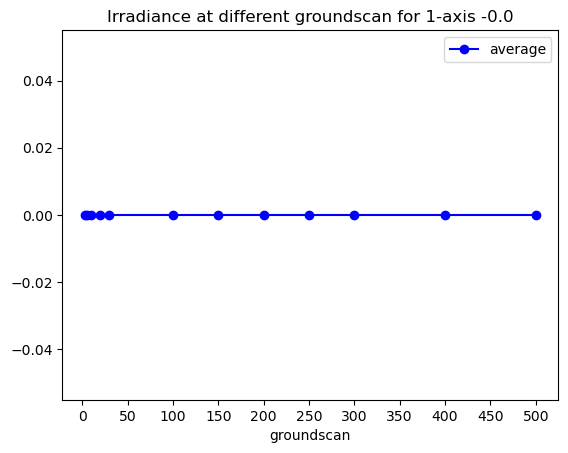

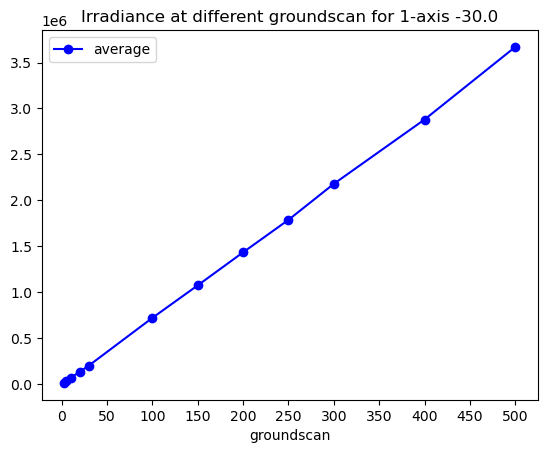

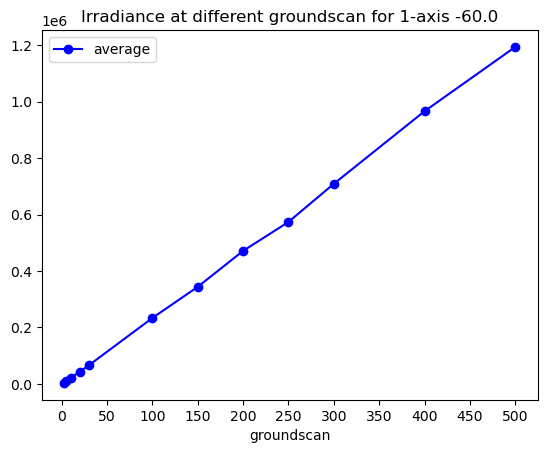

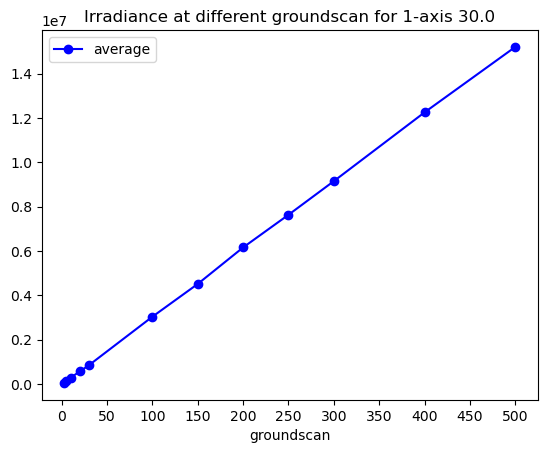

In [24]:
for i, angle in enumerate(angles):
    df = pd.DataFrame({
        'groundscan': sensorsgroundvalues,
        'average': resulsbyangle[angle]
    })

    df.plot(x='groundscan', y='average', marker='o', color='blue')
    plt.xticks(np.arange(0, 501, 50))
    plt.title(f'Irradiance at different groundscan for 1-axis {angle}')
    plt.show()

In [25]:
# one graph for all angles
resultsbysensor = {}

for i, sensorsground in enumerate(sensorsgroundvalues):
    resultsarr = []
    for i, angle in enumerate(angles):
        if (sensorsground, angle) in resultsdict:
            resultsarr.append(np.mean(resultsdict[(sensorsground, angle)]))
                          
    resultsbysensor[sensorsground] = np.mean(resultsarr)

In [26]:
resultsbysensor

{3: 20339.972777777777,
 5: 65350.0868,
 10: 125599.00859999999,
 20: 246361.00979999997,
 30: 370374.1924,
 100: 1329299.2834133347,
 150: 1977359.0423466645,
 200: 2688510.930083329,
 250: 3331996.432343995,
 300: 4013775.9512244496,
 400: 5368162.40371669,
 500: 6691724.655192021}

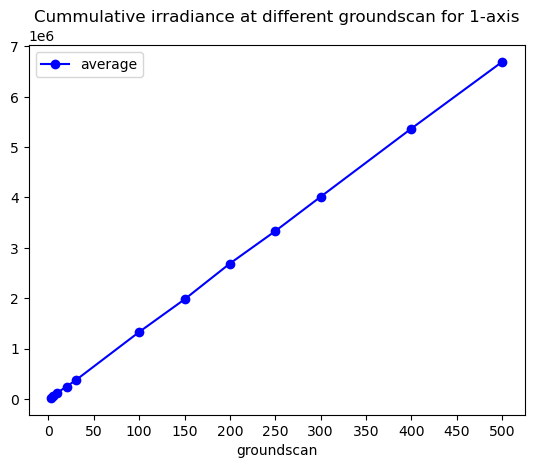

In [27]:
df1 = pd.DataFrame({
    'groundscan': sensorsgroundvalues,
    'average': resultsbysensor.values()
})

df1.plot(x='groundscan', y='average', marker='o', color='blue')
plt.xticks(np.arange(0, 501, 50))
plt.title('Cummulative irradiance at different groundscan for 1-axis')
plt.show()